# План
1. Напоминание: переобучение, регуляризация и кросс-валидация
2. Pipeline решения ML задачи
3. Подбор гиперпараметров и ансамблирование моделей на примере размеченных данных

# Переобучение и методы борьбы с ним
Переобучение --- это одна из главных проблем, с которыми сталкиваются модели машинного обучения. Эффект переобучения состоит в том, что модель, подстраиваясь под обучающую выборку, "обращает внимание" на закономерности в выборке, которые не проявляются в общем случае и имеют характер совпадения. 

Переобучение проявляется тем больше, чем больше степеней свободы имеет модель. 
### Примеры:
* Решающее дерево со слишком большой глубиной может идеально подстроиться под обучающую выборку. Параметры решающего дерева --- это решающие правила во всех вершинах (всего $\sim 2^n$ решающих правил в дереве глубины $n$).

* Алгоритм $k$ ближайших соседей подстраивается под обучаюущую выборку и может рассматриваться как эталонный пример переобучения: любой локальный шум в данных приведёт к ошибке. Параметрами Knn являются **все элементы обучающей выборки**.

* Линейный алгоритм, построенный для выборки слишком маленького размера со слишком большим количеством признаков неизбежно переобучится под обучающую выборку.

Во всех примерах мы видим, что при слишком большой сложности модели по сравнению с количеством элементов в обучающей выборке переобучение имеет место. Строго говоря, **переобучение есть всегда, когда имеет место принятие решения в условии неполных данных**, то есть всегда в машинном обучении.

<img src='https://drive.google.com/uc?id=1wQQ0tMAtZVhbeQgUVdiS7kfmMw7P7NM9'/>

Чтобы нивелировать эффект переобучения, нужно поймать момент, в который качество на тестовой выборке начинает увеличиваться с ростом сложности модели. В этот момент обучение стоит останавливать.

## Переобучение многочленов
Смоделируем переобучение сколонность к переобучению полиномиальной зависимости с ростом степени многочлена. Сгенерируем искусственные данные из линейной зависимости с шумом и восстановим зависимость с помощью многочленов степени 1, 3, 4, 7.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=1.5)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

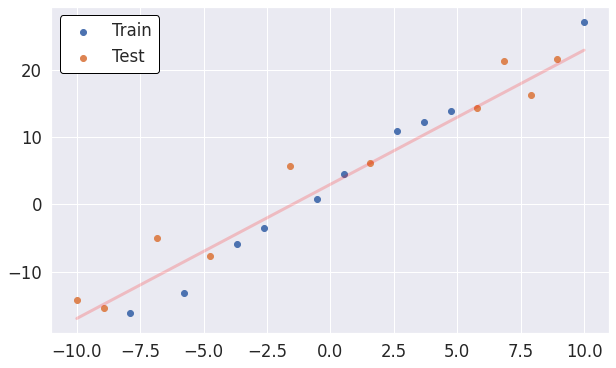

In [2]:
X = np.linspace(-10, 10, 20)

y = 2 * X + 3 + np.random.randn(20) * 3

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)
plt.figure(figsize=(10,6))
plt.scatter(X_train,y_train, label='Train')
plt.scatter(X_test,y_test, label='Test')
plt.plot(X, 2 * X + 3, color='red', lw=3, alpha = 0.2)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.show()

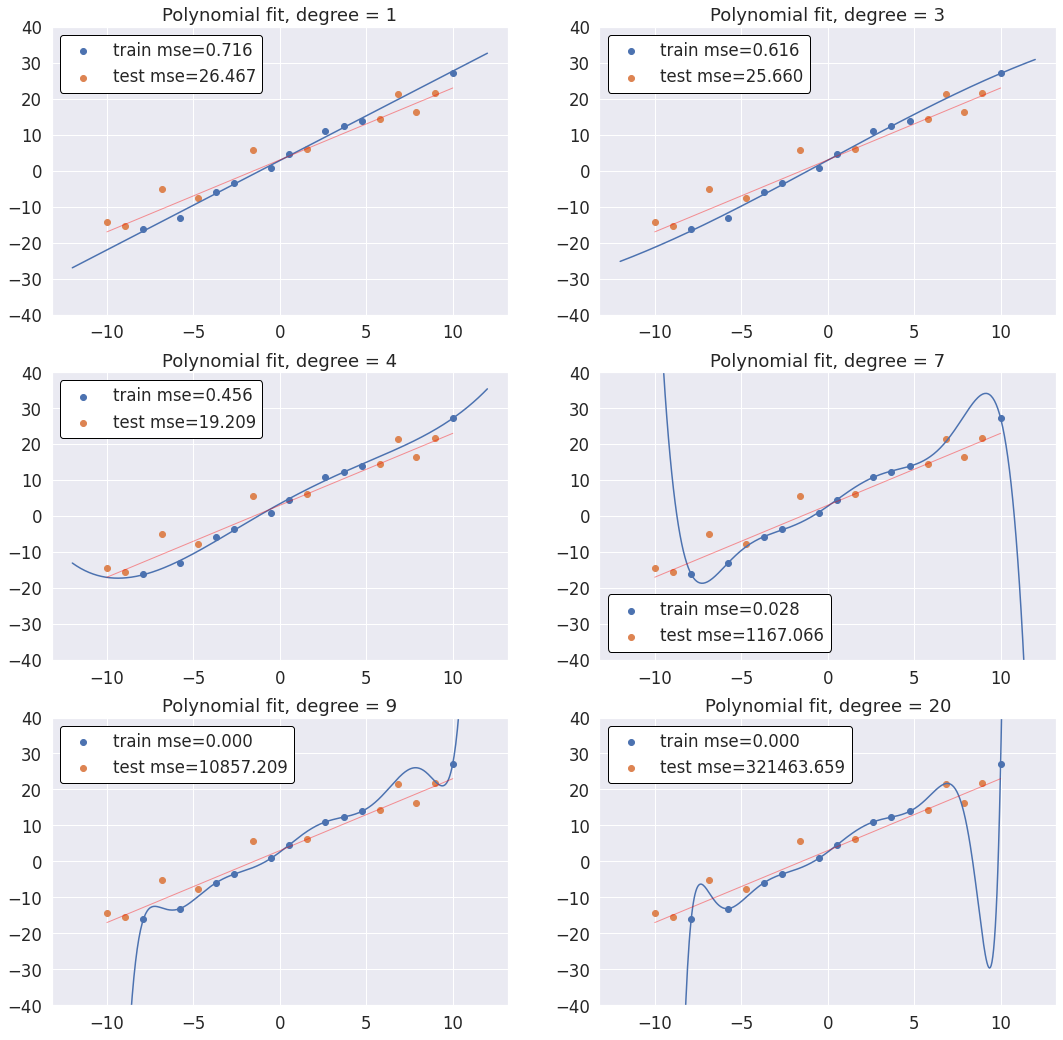

In [3]:
grid = np.linspace(-12, 12, 500)

fig, ax = plt.subplots(3, 2, figsize=(18,18))

ax = ax.ravel()

for i, deg in enumerate([1,3,4,7,9, 20]):
    
    poly = np.polyfit(X_train, y_train, deg)
    ax[i].set_title('Polynomial fit, degree = ' + str(deg))
    ax[i].scatter(X_train,y_train, 
                  label='train mse={:.3f}'.format(mean_squared_error(y_train, np.polyval(poly, X_train))))
    ax[i].scatter(X_test,y_test, 
                  label='test mse={:.3f}'.format(mean_squared_error(y_test, np.polyval(poly, X_test))))
    ax[i].set_ylim(-40, 40)
    ax[i].plot(grid, np.polyval(poly, grid))
    
    ax[i].plot(X, 2 * X + 3, color='red', lw=1, alpha = 0.4)
    legend_box = ax[i].legend(framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
fig.show()

$$||x-y||, \text{x, y - векторы в 2-мерном пространстве}$$
$$||x - y|| = \sqrt{(x_1 - y_1)^2 + (x_2-y_2)^2}$$

$$||x-y||, \text{x, y - векторы в n-мерном пространстве}$$
$$||x - y|| = \sqrt{(x_1 - y_1)^2 + ... + (x_n-y_n)^2}$$

### Идея 1: регуляризация
Суть регуляризации состоит в том, чтобы добавлять к функции потерь слагаемое, ограничивающее рост весов модели. Например, обычная версия линейной регрессии выглядит так:
$$\frac{\sum\limits_{i=1}^{\ell}\left|\left|\langle x^i, w\rangle - y^i\right|\right|^2}{\ell} \rightarrow \min_{w}.$$

Регуляризованная версия:
$$\frac{\sum\limits_{i=1}^{\ell}\left|\left|\langle x^i, w\rangle - y^i\right|\right|^2}{\ell} + \frac{1}{C}\left|\left|w\right|\right|^2\rightarrow \min_{w}.$$

Такая версия линейной регресси называется Ridge-регрессией.  
Есть также Lasso-регрессия и ElasticNet.

Обычная версия логрегрессии:
$$-\frac{1}{\ell}\left( \sum\limits_{y^i = 1}\ln\sigma(\langle x, w\rangle) + \sum\limits_{y^i = -1}\ln(1-\sigma(\langle x, w\rangle))\right)\rightarrow \min_{w}$$

Регуляризованная версия:

$$-\frac{1}{\ell}\left( \sum\limits_{y^i = 1}\ln\sigma(\langle x, w\rangle) + \sum\limits_{y^i = -1}\ln(1-\sigma(\langle x, w\rangle))\right) + \frac{1}{C}||w||^2\rightarrow \min_{w}$$

### Идея 2: кросс-валидация

<img src='https://drive.google.com/uc?id=19TOWCsLwIjNSmcHzu46f6JqY5TEefm9h' width=600/>
Картинка говорит сама за себя. Чтобы получить более стабильное предсказание и точно увидеть переобучение, можно использовать кросс-валидацию. Это ещё пригодится дальше в ноутбуке.

# Pipeline решения ML-задачи

![lifecycle.png](https://drive.google.com/uc?export=view&id=1ZVVA3knTV7M0sTANYF4kOSMAZWG_BB5j)

![pipeline.jpg](https://drive.google.com/uc?export=view&id=1wt86eJI3wDb4SuRKFdtjvqKDaW0UDLvz)

# Выбор оптимальной модели

Теперь мы потренируемся обучению, оценке и валидации моделей, подбору оптимальных гиперпараметров, смешиванию моделей. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k.

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=', ')
# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorical_indices = np.array([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split() #этот метод разделит датасет по колонкам как в массиве columns

df = df.replace('?', np.nan)

df = df.dropna()

df['salary'] = df['salary'].apply((lambda x: x=='>50K')) # Будем предсказывать 1(True), если зарплата больше 50K, 0(False) иначе

In [6]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorical_indices]]
categorial_data.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States


In [7]:
df['education'].unique(), len(df['education'].unique())

(array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', '7th-8th', 'Doctorate', 'Assoc-voc', 'Prof-school',
        '5th-6th', '10th', 'Preschool', '12th', '1st-4th'], dtype=object), 16)

### One-hot кодирование
Поскольку все алгоритмы машинного обучения, которые мы изучили, работают лишь с числовыми признаками, необходимо придумать способ обработки категориальных признаков, переводящий их в числовые. 
Одним из способов сделать это является One-hot кодирование. Его суть состоит в следующем. Пусть некоторая категориальная переменная (скажем, color) принимает $n$ различных значений (Red, Yellow, Green). Тогда можно создать $n$ новыx переменныx, соответствующих различным значениям категориального признака, каждая из которых равна 1 в том случае, если изначальный категориальный признак принимает такое значение, и 0 иначе. Принцип работы иллюстрирован на картинке.

<img src='https://drive.google.com/uc?id=17oipPzKv7JFU5Z94hBUzMb5zJJlpbwxj' width=700/>

В Pandas One-hot кодирование выполняется функцией pd.get_dummies. Сгенерируем One-hot признаки для нашего датасета. Сохраним полную матрицу объекты признаки в переменную X.

In [8]:
dummy_features = pd.get_dummies(categorial_data)

In [9]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X_origin = df.iloc[:, :-1]
X.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,50,83311,13,0,0,13,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,38,215646,9,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,53,234721,7,0,0,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,28,338409,13,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [10]:
y = df['salary']

In [11]:
X.shape, X_origin.shape

((30161, 104), (30161, 14))

Теперь всё готово для обучения алгоритмов.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    train_size=0.8,
                                                    random_state=42)

Напишем функцию, визуализирующую поиск оптимального гиперпараметра модели по сетке. Используем идею кросс-валидации.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [15]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    #param_scale - какую шкалу рисовать? обычную или логарифмическую

    parameters = {param_name: grid}                  #{название параметра: какие значения могут принимать}
    
    CV_model = GridSearchCV(estimator=model,         #какую модель подбираем (линейная регрессия, knn...)
                            param_grid=parameters,   #наша сетка с параметрами
                            cv=5,                    #количество фолдов в кросс валидации
                            scoring='f1',            #метрика, f1 - хорошая метрика для бинарной классификации (чем p ближе к 1, тем лучше)
                            n_jobs=-1,               #паралелльное вычисление фолдов
                            verbose=10)              #насколько часто нужно писать логирование (информацию)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        plt.fill_between(grid, means - 2 * error, means + 2 * error, 
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [17]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [np.array(np.linspace(4, 30, 8), dtype='int'), np.arange(1, 30)]
param_scales = ['log', 'ordinary']

Fitting 5 folds for each of 8 candidates, totalling 40 fits


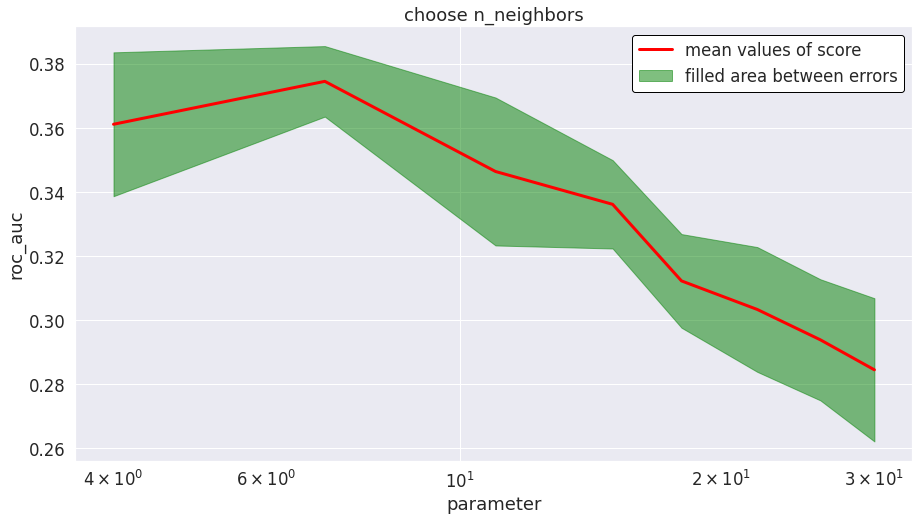

Fitting 5 folds for each of 29 candidates, totalling 145 fits


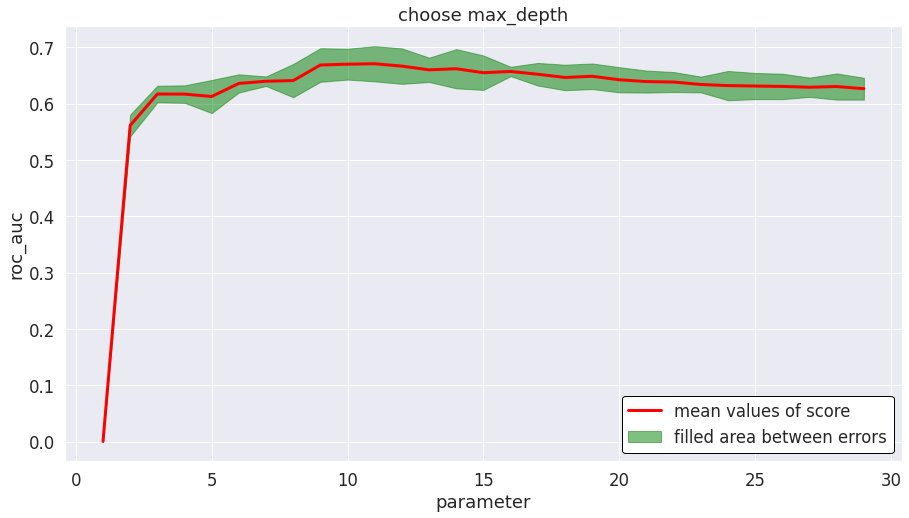

In [18]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)

Подберём параметр n_estimators в алгоритме случайный лес. Известно, что случайный лес не переобучается. Поэтому график качества будет монотонно возрастать. Следовательно, необходимо найти минимальное значение n_estimators, при котором качество не изменяется. 
Поскольку каждое дерево обучается независимо от остальных, достаточно обучить сразу лес из большого количества деревьев, а затем рассмотреть подмножества нужного размера из исходного множества деревьев.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [21]:
max_trees = 100

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

global_scores = []

for train_indices, val_indices in tqdm(kf.split(X_train), total=5):
    scores = []
    
    X_train_kf = X_train[train_indices]
    y_train_kf = y_train[train_indices]
    
    X_val_kf = X_train[val_indices]
    y_val_kf = y_train[val_indices]
    
    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_
    
    for number_of_trees in tqdm(values, leave=False):
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)
        
        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]

        scores.append(roc_auc_score(y_val_kf, thinned_forest.predict_proba(X_val_kf)[:, 1]))
    
    scores = np.array(scores)
    
    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

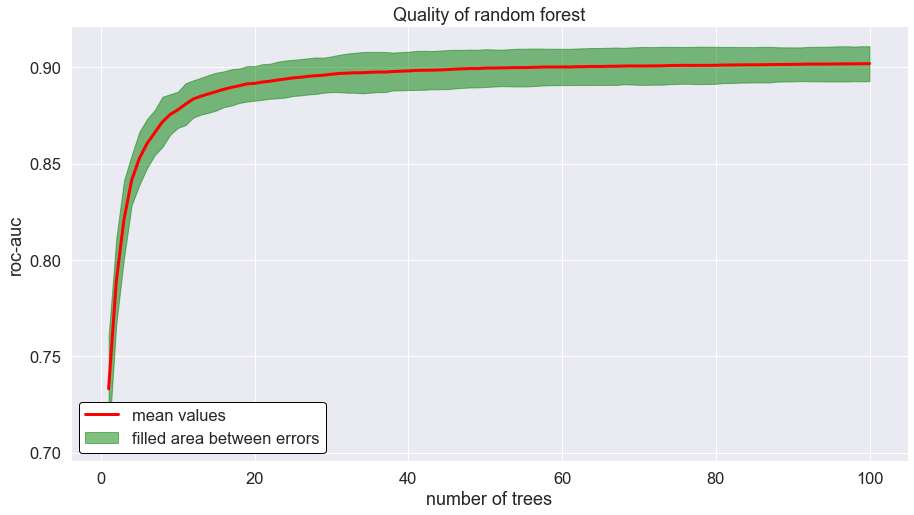

In [ ]:
mean_cross_val_score = global_scores.mean(axis=0)
std_cross_val_score = global_scores.std(axis=0)

plt.figure(figsize=(15,8))
plt.title('Quality of random forest')

plt.plot(values, mean_cross_val_score, label='mean values', color='red', lw=3)
plt.fill_between(values, 
                 mean_cross_val_score - 2 * std_cross_val_score, 
                 mean_cross_val_score + 2 * std_cross_val_score, 
                 color='green', 
                 label='filled area between errors',
                 alpha=0.5)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.xlabel('number of trees')
plt.ylabel('roc-auc')

plt.show()

### Нормировка признаков

Нормируем признаки и проделаем тот же эксперимент с алгоритмом ближайших соседей. Посмотрим, изменилось ли качество предсказания.

In [22]:
#Почему у нас получилась плохая модель на knn?
#мы не отнормировали признаки - чтобы улучшить модель и чтобы метрика расстояния работала хорошо - нужно отнормировать признаки
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

`StandardScaler` выполняет преобразование $$z = \frac{x - \mu}{\sigma}, \text{где $\sigma$ - стандартное отклонение, а  $\mu$ - среднее}$$

Fitting 5 folds for each of 8 candidates, totalling 40 fits


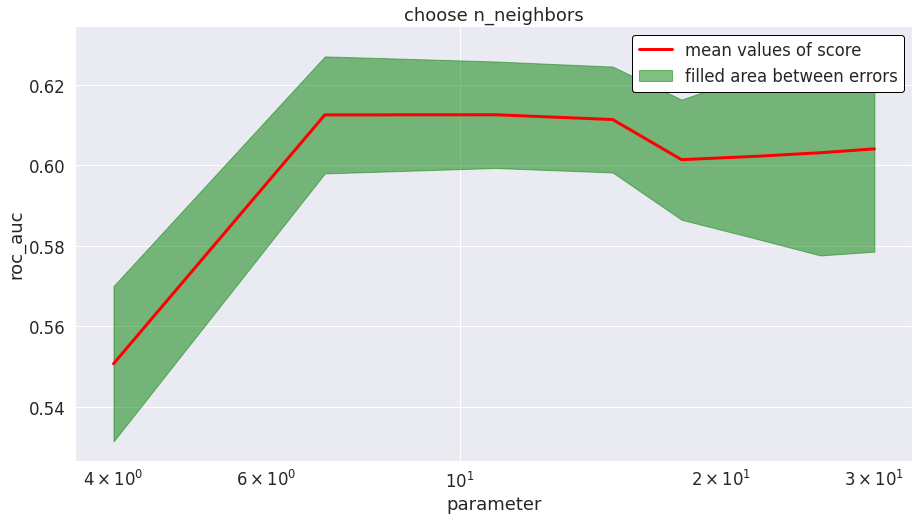

In [23]:
search_and_draw(X_train_scaled, y_train, KNeighborsClassifier(), 'n_neighbors', 
                np.array(np.linspace(4, 30, 8), dtype='int'), 'log');

Как и следовало ожидать, ни один из наших алгоритмов не побил случайный лес. Итак, видим, что на больших выборках бэггинг работает. Вычислим итоговое качество на test.

In [ ]:
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)  #n_estimators - количество деревьев (выбрали 50 смотря на график - после 50 качество почти не меняется)

model.fit(X_train, y_train)
y_train_predicted = model.predict_proba(X_train)[:, 1]
y_test_predicted = model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

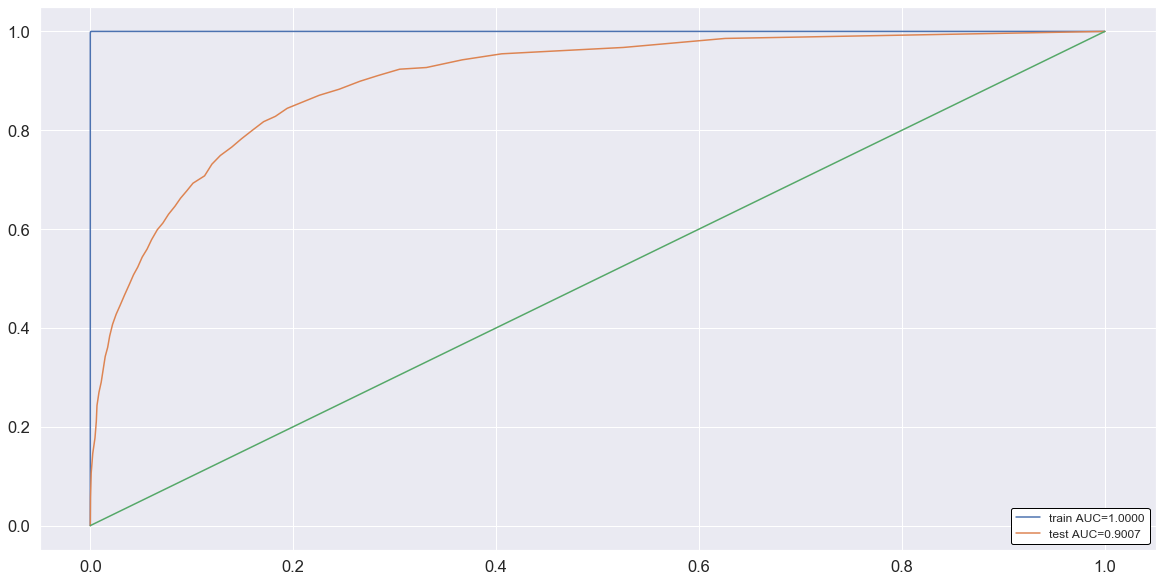

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

## Что ещё можно делать:

Мы подбирали оптимальный одномерный параметр для алгоритма. Можно также:

* Искать по сетке не только численные гиперпараметры, но и категориальные, например, метрику в алгоритме ближайших соседей или критерий ветвления в решающем дереве.

* Искать оптимальный параметр по многомерной сетке. Перебрать все возможные варианты здесь не выйдет, потому что на это уйдёт слишком много времени. Зато можно перебирать случайные точки по сетке. Эта процедура называется Grid Random Search.

# Стекинг

Идея стекинга состоит в том, чтобы обучать разнообразные алгоритмы и использовать их в качестве новых признаков объектов. 

Чтобы избежать переобучения, необходимо разделить обучающую выборку на n фолдов. Для предсказания ответов на k-ом фолде алгоритм обучается на оставшихся n-1 фолдах и предсказывает ответ на k-ом фолде. Такую схему обучения-предсказания реализует функция sklearn.model_selection.cross_val_predict.

In [ ]:
from sklearn.model_selection import cross_val_predict

Будем работать с тем же самым датасетом, что и ранее. Посмотрим, сумеем ли мы побить результаты случайного леса с помощью стекинга.

In [ ]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]
    
    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)[:, 1]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
models = []
models.append(KNeighborsClassifier(n_jobs=-1, n_neighbors=30))
models.append(LogisticRegression())
models.append(RandomForestClassifier(max_depth=3, n_estimators=50, n_jobs=-1))
models.append(RandomForestClassifier(max_depth=7, n_estimators=50, n_jobs=-1))
models.append(DecisionTreeClassifier(max_depth=8))

In [ ]:
meta_features_train = np.zeros((X_train.shape[0], 0))
meta_features_test = np.zeros((X_test.shape[0], 0))

In [ ]:
for model in tqdm(models):
    train, test = compute_meta_feature(model, X_train, X_test, y_train, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

In [ ]:
stacking_model = LogisticRegression()
stacking_model.fit(meta_features_train, y_train)

y_train_predicted = stacking_model.predict_proba(meta_features_train)[:, 1]
y_test_predicted = stacking_model.predict_proba(meta_features_test)[:, 1]

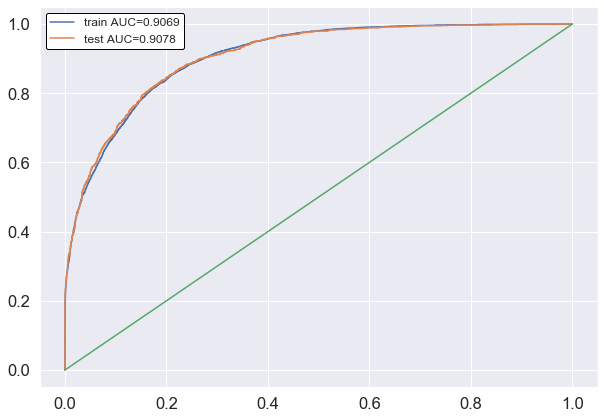

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

# Бустинг

Попробуем в пару-тройку строк побить всё то качество, которое мы так усердно искали.

In [ ]:
# если этого модуля нет, то нужно раскомментировать следующую строчку и запустить
#!pip install xgboost

In [ ]:
import xgboost

In [ ]:
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

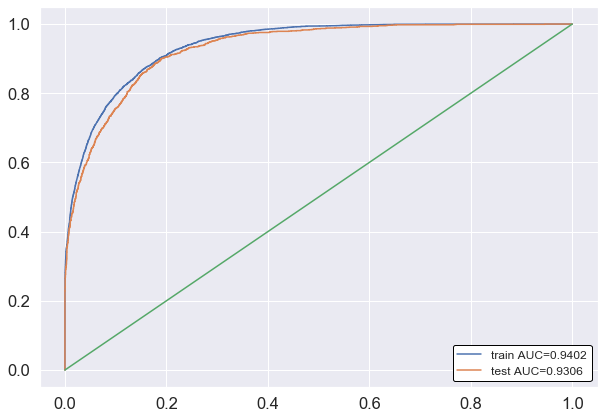

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Круто, да? А теперь попробуем "отечественного" производителя - CatBoost от Яндекса.

In [ ]:
# если этого модуля нет, то нужно раскомментировать следующую строчку и запустить
#!pip install catboost

In [ ]:
import catboost # документация: https://catboost.ai/docs

In [ ]:
# CatBoost умеет работать с категориальными признаками сам
X_train_origin, X_test_origin, _, _ = train_test_split(X_origin.values, y.values, 
                                                       train_size=0.8, 
                                                       random_state=42)

![docs_one_hot.png](https://drive.google.com/uc?export=view&id=119U7_cTX8imN13rr3Bi-vevHjo7kEXr6)

(из документации CatBoost)

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                             cat_features=categorical_indices)

boosting_model.fit(X_train_origin, y_train)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

Learning rate set to 0.175479
0:	learn: 0.5380235	total: 90.4ms	remaining: 18s
1:	learn: 0.4479261	total: 187ms	remaining: 18.5s
2:	learn: 0.3998054	total: 250ms	remaining: 16.4s
3:	learn: 0.3720098	total: 338ms	remaining: 16.5s
4:	learn: 0.3591503	total: 464ms	remaining: 18.1s
5:	learn: 0.3471251	total: 552ms	remaining: 17.9s
6:	learn: 0.3356031	total: 632ms	remaining: 17.4s
7:	learn: 0.3267387	total: 716ms	remaining: 17.2s
8:	learn: 0.3217937	total: 797ms	remaining: 16.9s
9:	learn: 0.3175740	total: 915ms	remaining: 17.4s
10:	learn: 0.3137769	total: 1.02s	remaining: 17.5s
11:	learn: 0.3116092	total: 1.11s	remaining: 17.4s
12:	learn: 0.3087479	total: 1.21s	remaining: 17.5s
13:	learn: 0.3075583	total: 1.28s	remaining: 17s
14:	learn: 0.3051900	total: 1.36s	remaining: 16.8s
15:	learn: 0.3033366	total: 1.44s	remaining: 16.5s
16:	learn: 0.3019215	total: 1.54s	remaining: 16.6s
17:	learn: 0.3012249	total: 1.61s	remaining: 16.3s
18:	learn: 0.3003474	total: 1.66s	remaining: 15.8s
19:	learn: 0.2

161:	learn: 0.2539225	total: 12.9s	remaining: 3.02s
162:	learn: 0.2537650	total: 12.9s	remaining: 2.93s
163:	learn: 0.2535782	total: 13s	remaining: 2.85s
164:	learn: 0.2533838	total: 13s	remaining: 2.77s
165:	learn: 0.2532206	total: 13.1s	remaining: 2.69s
166:	learn: 0.2531381	total: 13.1s	remaining: 2.6s
167:	learn: 0.2529367	total: 13.2s	remaining: 2.52s
168:	learn: 0.2528503	total: 13.3s	remaining: 2.44s
169:	learn: 0.2527856	total: 13.4s	remaining: 2.36s
170:	learn: 0.2526594	total: 13.4s	remaining: 2.28s
171:	learn: 0.2523432	total: 13.5s	remaining: 2.2s
172:	learn: 0.2523068	total: 13.6s	remaining: 2.12s
173:	learn: 0.2521094	total: 13.7s	remaining: 2.04s
174:	learn: 0.2519952	total: 13.7s	remaining: 1.96s
175:	learn: 0.2517683	total: 13.8s	remaining: 1.88s
176:	learn: 0.2516162	total: 13.9s	remaining: 1.8s
177:	learn: 0.2515075	total: 14s	remaining: 1.72s
178:	learn: 0.2514175	total: 14s	remaining: 1.65s
179:	learn: 0.2512673	total: 14.1s	remaining: 1.57s
180:	learn: 0.2511304	t

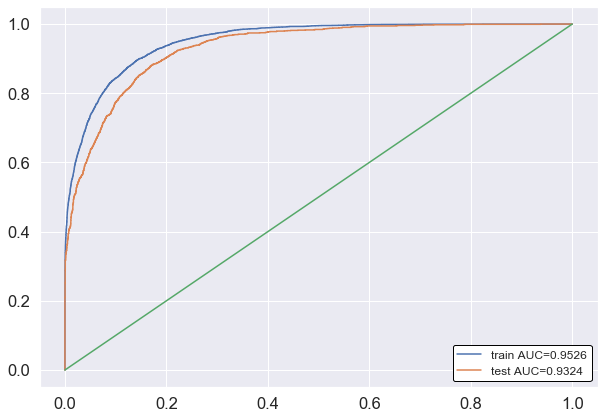

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, silent=True,
                                             cat_features=categorical_indices,
                                             eval_metric='AUC')
boosting_model.grid_search({'l2_leaf_reg': np.linspace(0, 1, 20)}, 
                           X_train_origin, 
                           y_train, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.9227514	best: 0.9227514 (0)	total: 13.9s	remaining: 4m 24s
1:	loss: 0.9238508	best: 0.9238508 (1)	total: 29.3s	remaining: 4m 23s
2:	loss: 0.9236316	best: 0.9238508 (1)	total: 44.8s	remaining: 4m 13s
3:	loss: 0.9233129	best: 0.9238508 (1)	total: 1m 2s	remaining: 4m 8s
4:	loss: 0.9237572	best: 0.9238508 (1)	total: 1m 15s	remaining: 3m 45s
5:	loss: 0.9232062	best: 0.9238508 (1)	total: 1m 26s	remaining: 3m 22s
6:	loss: 0.9239117	best: 0.9239117 (6)	total: 1m 40s	remaining: 3m 6s
7:	loss: 0.9231683	best: 0.9239117 (6)	total: 1m 58s	remaining: 2m 58s
8:	loss: 0.9233554	best: 0.9239117 (6)	total: 2m 15s	remaining: 2m 45s
9:	loss: 0.9232125	best: 0.9239117 (6)	total: 2m 38s	remaining: 2m 38s
10:	loss: 0.9232851	best: 0.9239117 (6)	total: 2m 58s	remaining: 2m 25s
11:	loss: 0.9233200	best: 0.9239117 (6)	total: 3m 21s	remaining: 2m 14s
12:	loss: 0.9234769	best: 0.9239117 (6)	total: 3m 57s	remaining: 2m 7s
13:	loss: 0.9236351	best: 0.9239117 (6)	total: 4m 17s	remaining: 1m 50s
14:	loss:

{'params': {'l2_leaf_reg': 0.3157894736842105},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
   